# 1.0 Libraries

In [3]:
!pip install langid
!pip install gensim
!pip install -U spacy
!python -m spacy download it_core_news_sm
!wget https://github.com/explosion/sense2vec/releases/download/v1.0.0/s2v_reddit_2015_md.tar.gz
!tar -xzvf s2v_reddit_2015_md.tar.gz
!pip install sense2vec

  Using cached langid-1.1.6.tar.gz (1.9 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=f5df8235328216d109b15cca8df4c054755b11b596c63d095e2256c1adf38c43
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
--2024-04-04 00:55:04--  https://github.com/explosion/sense2vec/releases/download/v1.0.0/s2v_reddit_2015_md.tar.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.11

In [19]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

import re
import json
import gensim.downloader as api

import langid
from gensim.models import Word2Vec
import spacy

from sense2vec import Sense2Vec
import random

import torch
from transformers import RobertaTokenizer
from transformers import RobertaForMultipleChoice
from torch.distributions import Categorical
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

Mounted at /content/gdrive


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2.0 Set up

In [5]:
def load_data(data_path, gold_path):
  hypernyms_dict = {}
  with open(data_path, "r", encoding = 'utf-8') as data_file, open(gold_path, "r", encoding = 'utf-8') as gold_file:
    for data_line, gold_line in zip(data_file, gold_file):
      term_list = [term for term in data_line.split()[:-1]]
      term = " ".join(term_list)
      hypernyms = [hypernym.replace("\n", "") for hypernym in gold_line.split("\t")]
      hypernyms_dict[term] = hypernyms
  return hypernyms_dict

In [6]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/MNLP - HW1 - task 26/SemEval2018-Task9/SemEval2018-Task9/{split}/data/1B.italian.{split}.data.txt"
gold_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/MNLP - HW1 - task 26/SemEval2018-Task9/SemEval2018-Task9/{split}/gold/1B.italian.{split}.gold.txt"

# italian training data
train_data_path = data_path.format(split = 'training')
train_gold_path = gold_path.format(split = 'training')
train_hypernyms = load_data(train_data_path, train_gold_path)

# italian test data
test_data_path = data_path.format(split = 'test')
test_gold_path = gold_path.format(split = 'test')
test_hypernyms = load_data(test_data_path, test_gold_path)

In [7]:
def load_vocabulary(vocabulary_path):
  with open(vocabulary_path, "r", encoding = 'utf-8') as vocabulary_file:
    vocabulary = vocabulary_file.read().splitlines()
  return vocabulary

def clean_vocabulary(vocabulary):
  new_vocabulary = []
  for word in vocabulary:
    if word.isalpha(): # filter out numeric terms
      language, confidence = langid.classify(word)
      if language == 'it': # filter out non-italian words
        new_vocabulary.append(word)
  return new_vocabulary

In [8]:
# italian vocabulary
vocabulary_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/MNLP - HW1 - task 26/SemEval2018-Task9/SemEval2018-Task9/vocabulary/1B.italian.vocabulary.txt"
vocabulary = load_vocabulary(vocabulary_path)
print("Number of terms in the vocabulary: ", len(vocabulary), "\n")

# filtered italian vocabulary
vocabulary = clean_vocabulary(vocabulary)
for sublist_train, sublist_test in zip(train_hypernyms.values(), test_hypernyms.values()):
  vocabulary.extend(sublist_train)
  vocabulary.extend(sublist_test)

vocabulary = list(set(vocabulary)) # to avoid duplicates
print("Number of terms in the filtered vocabulary: ", len(vocabulary), "\n")
vocabulary[:20] # preview of the first 20 terms

Number of terms in the vocabulary:  79715 

Number of terms in the filtered vocabulary:  15786 



['geopolitico',
 'trastullare',
 'stampante',
 'corazzieri',
 'inseminare',
 'impedenza',
 'appezzato',
 'dissestato',
 'esagramma',
 'cassatella',
 'falla',
 'prostrazione',
 'concimazione',
 'bigliardo',
 'dimostrabile',
 'maletto',
 'piattaforma',
 'porticato',
 'detonatore',
 'segretezza']

# 3.0 Create entries

In [9]:
# word2vec model using existing vocabulary
sentences = [vocabulary]
w2v_model = Word2Vec(sentences, min_count=1)

In [10]:
# sense2vec model
s2v_model = Sense2Vec().from_disk('./s2v_old')

In [11]:
sense = s2v_model.get_best_sense("gatto")
s2v_model.most_similar(sense, n=5)

[('frutto|NOUN', 0.8995),
 ('sapore|NOUN', 0.899),
 ('biglietto|NOUN', 0.8961),
 ('integrazione|NOUN', 0.8921),
 ('addosso|NOUN', 0.8905)]

In [12]:
def find_distractors(hypernym, data, term, num_distractors):
  # sense = s2v_model.get_best_sense(hypernym)
  # if sense:
  #   distractors = s2v_model.most_similar(sense, n=5)
  #   filtered_distractors = [distractor[0].split("|")[0].replace("_", " ") for distractor in distractors if distractor[0].split("|")[0].replace("_", " ") not in data[term]]
  #   return filtered_distractors[:num_distractors]
  # else:
  distractors = w2v_model.wv.most_similar(hypernym, topn = 5)
  filtered_distractors = [distractor[0] for distractor in distractors if distractor[0] not in data[term]]
  return filtered_distractors[:num_distractors]

def save_jsonl(file_path, data):
  id_seq = 0
  with open(file_path, "w") as output_file:
    for term, hypernyms in data.items():
      for hypernym in hypernyms:
        distractors = find_distractors(hypernym, data, term, num_distractors = 3)
        entries = (hypernym, *distractors)
        choices = list(entries)
        random.shuffle(choices) # to create randomness
        reformatted_json_data = {
              'id' : id_seq,
              'text': term,
              'choices': choices,
              'label' : choices.index(hypernym)
        }
        json.dump(reformatted_json_data, output_file)
        output_file.write("\n")
        id_seq +=1

def read_lines_jsonl(file_path, num_lines):
  with open(file_path, 'r') as f:
    json_list = list(f)
    for line in json_list[:num_lines]:
      data = json.loads(line)
      print(data)

In [13]:
# train jsonl file
save_jsonl("hypernym_discovery-task26-train-data.jsonl", train_hypernyms)
read_lines_jsonl("hypernym_discovery-task26-train-data.jsonl", num_lines = 5) # preview of the first 10 lines

{'id': 0, 'text': 'sesto', 'choices': ['scarlattina', 'grado', 'giocata', 'civilizzato'], 'label': 1}
{'id': 1, 'text': 'sesto', 'choices': ['fondo', 'oggetto celeste', 'numero ordinale', 'precettazione'], 'label': 2}
{'id': 2, 'text': 'sesto', 'choices': ['autoconservazione', 'frazione', 'cesiomaggiore', 'ridondanza'], 'label': 1}
{'id': 3, 'text': 'sesto', 'choices': ['situazione difficile', 'stampa', 'tentennante', 'carica'], 'label': 3}
{'id': 4, 'text': 'Sigillo', 'choices': ['banzi', 'ammaliatrice', 'comune', 'discriminatorio'], 'label': 2}


In [14]:
# test jsonl file
save_jsonl("hypernym_discovery-task26-test-data.jsonl", test_hypernyms)
read_lines_jsonl("hypernym_discovery-task26-train-data.jsonl", num_lines = 10) # preview of the first 10 lines

{'id': 0, 'text': 'sesto', 'choices': ['scarlattina', 'grado', 'giocata', 'civilizzato'], 'label': 1}
{'id': 1, 'text': 'sesto', 'choices': ['fondo', 'oggetto celeste', 'numero ordinale', 'precettazione'], 'label': 2}
{'id': 2, 'text': 'sesto', 'choices': ['autoconservazione', 'frazione', 'cesiomaggiore', 'ridondanza'], 'label': 1}
{'id': 3, 'text': 'sesto', 'choices': ['situazione difficile', 'stampa', 'tentennante', 'carica'], 'label': 3}
{'id': 4, 'text': 'Sigillo', 'choices': ['banzi', 'ammaliatrice', 'comune', 'discriminatorio'], 'label': 2}
{'id': 5, 'text': 'Sigillo', 'choices': ['municipalità', 'tiburzio', 'gabbiano', 'manzoniano'], 'label': 0}
{'id': 6, 'text': 'Sigillo', 'choices': ['colonnato', 'comune italiano', 'stravaganza', 'feletto'], 'label': 1}
{'id': 7, 'text': 'Sigillo', 'choices': ['ridondanza', 'autoconservazione', 'frazione', 'cesiomaggiore'], 'label': 2}
{'id': 8, 'text': 'Sigillo', 'choices': ['tartarico', 'motore', 'lagnare', 'paese'], 'label': 3}
{'id': 9, 't

# 4.0 Prompt formulation

In [15]:
prompts = [
    "Il termine '{text}' può essere iperonimo di: \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}",
    "Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}",
    "Scegli l'iperonimo del termine '{text}': \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"
]

In [16]:
for prompt in prompts:
  print(prompt)
  print(" ")

Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
 
Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
 
Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
 


In [17]:
def save_prompts_jsonl(prompts, file_path):
  json_prompts = []
  for prompt in prompts:
    json_prompts.append({"prompt": prompt})

  with open(file_path, "w") as output_file:
    for json_prompt in json_prompts:
      json.dump(json_prompt, output_file)
      output_file.write("\n")

In [18]:
save_prompts_jsonl(prompts, "hypernym_discovery-task26-json.jsonl")
read_lines_jsonl("hypernym_discovery-task26-json.jsonl", num_lines = 3)

{'prompt': "Il termine '{text}' può essere iperonimo di: \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}
{'prompt': "Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}
{'prompt': "Scegli l'iperonimo del termine '{text}': \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}


# 5.0 Prompts Evaluation

In [30]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [41]:
def evaluate_prompt(tokenizer, model, prompt, data_file):
  formatted_prompts, y_true, y_pred, score = [], [], [], []

  with open(data_file, "r") as f:
    json_data = list(f)
    for line in json_data:
      pair = json.loads(line)
      id = pair['id']
      text = pair['text']
      choices = pair['choices']
      label = pair['label']

      formatted_prompt = prompt.format(text = text, option1 = choices[0], option2 = choices[1], option3 = choices[2], option4 = choices[3])
      input = tokenizer(formatted_prompt, truncation=True, return_tensors = "pt").to(device)

      with torch.no_grad():
        output = model(input["input_ids"].to(device))

      probabilities = torch.softmax(output["logits"][0], -1).tolist()

      predicted_label = np.argmax(probabilities)
      prediction_score = probabilities[predicted_label]

      formatted_prompts.append(formatted_prompt)
      y_true.append(label)
      y_pred.append(predicted_label)
      score.append(prediction_score)

    return formatted_prompts, y_true, y_pred, score


def visualize_results(results, num_results):
  for prompt in range(len(results)):
    for n in range(num_results):
      print("Prompt: ", results[prompt][0][n])
      print("True label: ", results[prompt][1][n])
      print("Predicted label: ", results[prompt][2][n])
      print("Prediction score: ", round(results[prompt][3][n], 3))
      print(" ")

In [42]:
def compute_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
  recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
  f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
  cf_matrix = confusion_matrix(y_true, y_pred)
  return accuracy, precision, recall, f1, cf_matrix


def print_confusion_matrix(metrics, type):
  for n in range(len(metrics)):
    print(f"{type} Confusion Matrix for the Prompt {n}")
    print("Prompt: ", prompts[n])

    # Confusion Matrix Plot
    cf_matrix = metrics[n][4]
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.heatmap(cf_matrix, annot = True, fmt = '.0f')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

    print("Total Predictions: ", np.sum(cf_matrix))
    print("Correct Predictions: ", np.trace(cf_matrix))
    print("----------------------------------------------------------------")
    print(" ")

def print_overall_statistics(train_metrics, test_metrics, prompts):
  comparison_table = []
  for id, prompt in enumerate(prompts):
    data = {}
    for dtype, metrics in zip(['Train', 'Test'], [train_metrics, test_metrics]):
      accuracy, precision, recall, f1, cf_matrix = metrics[id]
      data[f'{dtype} Accuracy'] = round(accuracy, 3)
      data[f'{dtype} Precision'] = round(precision, 3)
      data[f'{dtype} Recall'] = round(recall, 3)
      data[f'{dtype} F1-score'] = round(f1, 3)
    comparison_table.append(data)
  return pd.DataFrame(comparison_table).transpose()

## 5.1 mDeBERTa Multilingual

In [43]:
model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
tokenizer_mDeBERTa = AutoTokenizer.from_pretrained(model_name)
model_mDeBERTa = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

In [44]:
train_results, test_results = [], []

for prompt in prompts:
  formatted_prompt, y_true, y_pred, score = evaluate_prompt(tokenizer_mDeBERTa, model_mDeBERTa, prompt, "hypernym_discovery-task26-train-data.jsonl")
  train_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(tokenizer_mDeBERTa, model_mDeBERTa,  prompt, "hypernym_discovery-task26-test-data.jsonl")
  test_results.append([formatted_prompt, y_true, y_pred, score])


In [45]:
visualize_results(train_results, num_results = 2) # preview of the first 2 train results for each prompt

Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) impraticabile 
 b) abbondanzio 
 c) riconnettere 
 d) grado
True label:  3
Predicted label:  1
Prediction score:  0.996
 
Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) sfracellare 
 b) riallacciare 
 c) indolenzimento 
 d) numero ordinale
True label:  3
Predicted label:  1
Prediction score:  0.999
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) impraticabile 
 b) abbondanzio 
 c) riconnettere 
 d) grado
True label:  3
Predicted label:  1
Prediction score:  0.768
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) sfracellare 
 b) riallacciare 
 c) indolenzimento 
 d) numero ordinale
True label:  3
Predicted label:  1
Prediction score:  0.959
 
Prompt:  Scegli l'iperonimo del termine 'sesto': 
 a) impraticabile 
 b) abbondanzio 
 c) riconnettere 
 d) grado
True label:  3
Predicted label:  2
Prediction score:  0.685
 
Prompt:  Scegli l'iper

In [47]:
train_metrics, test_metrics = [], []

for prompt in range(len(prompts)):
  accuracy, precision, recall, f1, cf_matrix = compute_metrics(train_results[prompt][1], train_results[prompt][2])
  train_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(test_results[prompt][1], test_results[prompt][2])
  test_metrics.append([accuracy, precision, recall, f1, cf_matrix])

### Confusion Matrices

Train Confusion Matrix for the Prompt 0
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


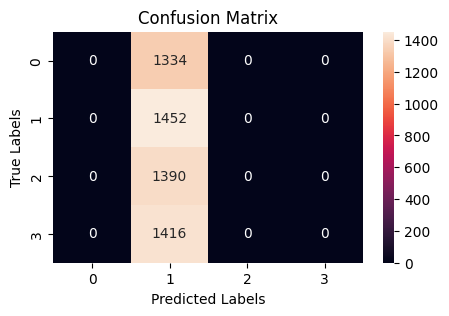

Total Predictions:  5592
Correct Predictions:  1452
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 1
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


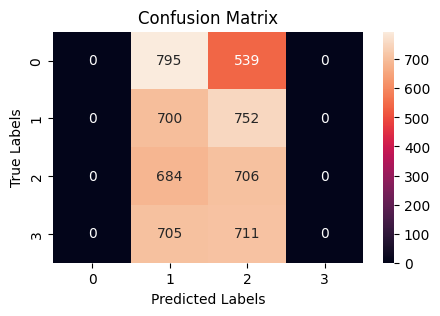

Total Predictions:  5592
Correct Predictions:  1406
----------------------------------------------------------------
 
Train Confusion Matrix for the Prompt 2
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


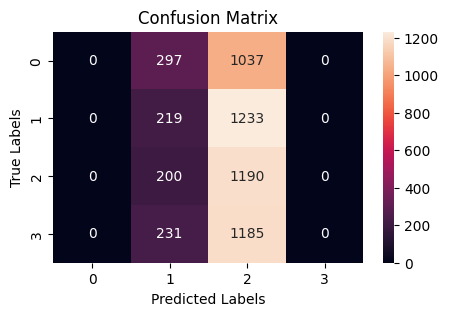

Total Predictions:  5592
Correct Predictions:  1409
----------------------------------------------------------------
 


In [48]:
# Train Confusion Matrix for each prompt
print_confusion_matrix(train_metrics, "Train")

Test Confusion Matrix for the Prompt 0
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


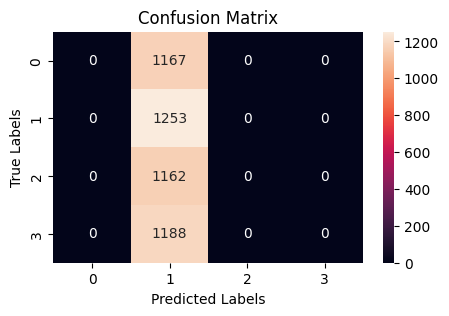

Total Predictions:  4770
Correct Predictions:  1253
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 1
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


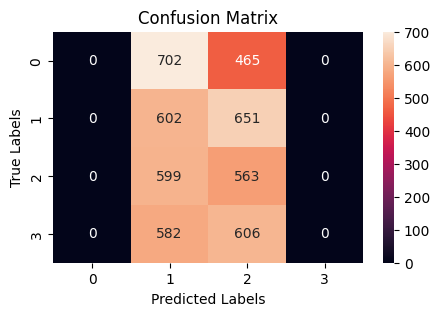

Total Predictions:  4770
Correct Predictions:  1165
----------------------------------------------------------------
 
Test Confusion Matrix for the Prompt 2
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}


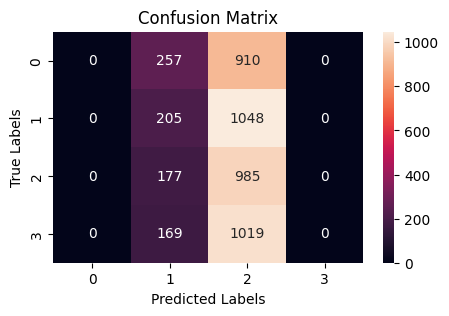

Total Predictions:  4770
Correct Predictions:  1190
----------------------------------------------------------------
 


In [49]:
# Test Confusion Matrix for each prompt
print_confusion_matrix(test_metrics, "Test")

### Overall Statistics

In [50]:
print_overall_statistics(train_metrics, test_metrics, prompts)

,0,1,2
Train Accuracy,0.260,0.251,0.252
Train Precision,0.808,0.620,0.616
Train Recall,0.260,0.251,0.252
Train F1-score,0.107,0.169,0.145
Test Accuracy,0.263,0.244,0.249
Test Precision,0.806,0.617,0.621
Test Recall,0.263,0.244,0.249
Test F1-score,0.109,0.164,0.146


## 5.2 Zero Shot Text Classification

In [54]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

bert_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
bert_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli').to(device)

In [64]:
def evaluate_prompt_2(tokenizer, model, prompt, data_file):
  formatted_prompts, y_true, y_pred, score = [], [], [], []

  with open(data_file, "r") as f:
    json_data = list(f)
    for line in json_data:
      pair = json.loads(line)
      id = pair['id']
      text = pair['text']
      choices = pair['choices']
      label = pair['label']

      formatted_prompt = prompt.format(text = text, option1 = choices[0], option2 = choices[1], option3 = choices[2], option4 = choices[3])
      input = tokenizer(formatted_prompt, truncation=True, return_tensors = "pt").to(device)

      output = classifier(input, choices, hypothesis_template="Questo esempio è {}.")
      predicted_label = np.argmax(output['scores'])
      prediction_score = output['scores'][predicted_label]

      formatted_prompts.append(formatted_prompt)
      y_true.append(label)
      y_pred.append(predicted_label)
      score.append(prediction_score)

    return formatted_prompts, y_true, y_pred, score

In [ ]:
train_results, test_results = [], []

for prompt in prompts:
  formatted_prompt, y_true, y_pred, score = evaluate_prompt_2(tokenizer_mDeBERTa, model_mDeBERTa, prompt, "hypernym_discovery-task26-train-data.jsonl")
  train_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt_2(tokenizer_mDeBERTa, model_mDeBERTa,  prompt, "hypernym_discovery-task26-test-data.jsonl")
  test_results.append([formatted_prompt, y_true, y_pred, score])

In [ ]:
visualize_results(train_results, num_results = 2) # preview of the first 2 train results for each prompt

In [ ]:
train_metrics, test_metrics = [], []

for prompt in range(len(prompts)):
  accuracy, precision, recall, f1, cf_matrix = compute_metrics(train_results[prompt][1], train_results[prompt][2])
  train_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(test_results[prompt][1], test_results[prompt][2])
  test_metrics.append([accuracy, precision, recall, f1, cf_matrix])

In [ ]:
# Train Confusion Matrix for each prompt
print_confusion_matrix(train_metrics, "Train")